# Rare variant association study

The exercises in this notebook were adopted from: 
https://github.com/joellembatchou/SISG2022_Association_Mapping/blob/master/code/Session07_exercises.R

# Set up

## Paths

In [2]:
DIR_MAIN = '..'

In [3]:
%%bash -s "$DIR_MAIN"
DIR_MAIN=$1

ls $DIR_MAIN

Workshop_regeneron_UNAM_AZ.docx
code
data
material
notes
slides
tools
~$rkshop_regeneron_UNAM_AZ.docx


## Tools

A list of tools: PLINK2.

In [4]:
PLINK = f'{DIR_MAIN}/tools/plink2'

In [5]:
%%bash -s "$PLINK"
PLINK=$1

$PLINK --version

PLINK v2.00a3.7 64-bit (24 Oct 2022)


In [6]:
REGENIE='/usr/local/Caskroom/miniconda/base/envs/regenie/bin/regenie'

In [7]:
%%bash -s "$REGENIE"
REGENIE=$1

$REGENIE --version

v3.2.6.gz


## Datasets

In [36]:
DIR_DATA = f'{DIR_MAIN}/data/'
D1_BFILE = f'{DIR_DATA}/rv_geno_chr1'
D1_PHENO = f'{DIR_DATA}/rv_pheno.txt'

## R enviroment

In [9]:
%%bash
R --version

R version 4.3.0 (2023-04-21) -- "Already Tomorrow"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-apple-darwin21.6.0 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
https://www.gnu.org/licenses/.



In [10]:
 import rpy2.ipython

In [11]:
%%capture
%load_ext rpy2.ipython

In [12]:
%%R
 print('Hello World from R!')

[1] "Hello World from R!"


In [15]:
%%R
library(tidyverse)
library(data.table)

In [21]:
%%R
library(BEDMatrix)
library(SKAT)
library(ACAT)

# RVAS on `rv_geno_chr1` dataset

## Data preparation

Extract a subset of markers for downstream association testing and store a new bed/bam/file fileset.

In [27]:
%%bash -s "$PLINK" "$D1_BFILE" "$D1_PHENO"
PLINK=$1
D1_BFILE=$2
D1_PHENO=$3

cmd="$PLINK --bfile $D1_BFILE 
    --max-maf 0.01 --maj-ref force
    --make-bed --out rv_geno_chr1_subset"
eval $cmd

PLINK v2.00a3.7 64-bit (24 Oct 2022)           www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to rv_geno_chr1_subset.log.
Options in effect:
  --bfile ../data//rv_geno_chr1
  --maj-ref force
  --make-bed
  --max-maf 0.01
  --out rv_geno_chr1_subset

Start time: Tue Apr 25 12:11:20 2023
16384 MiB RAM detected; reserving 8192 MiB for main workspace.
Using up to 12 threads (change this with --threads).
9953 samples (4942 females, 5011 males; 9953 founders) loaded from
../data//rv_geno_chr1.fam.
78 variants loaded from ../data//rv_geno_chr1.bim.
1 binary phenotype loaded (9953 cases, 0 controls).
Calculating allele frequencies... 0%0%done.
23 variants removed due to allele frequency threshold(s)
(--maf/--max-maf/--mac/--max-mac).
55 variants remaining after main filters.
Writing rv_geno_chr1_subset.fam ... done.
Writing rv_geno_chr1_subset.bim ... done.
Writing rv_geno_chr1_subset.bed ... 0%done.
End time: Tue Ap

## Load genotypes into R

In [29]:
%%R 
bfile = 'rv_geno_chr1_subset'

# genotypes are still stored in files 
# and can be loaded into RAM by small chunks 
g = BEDMatrix(bfile, simple_names = TRUE) 

# genotypes are converted to a regular R matrix and all data is in RAM
# !NB! not recommended for real large datasets
G = as.matrix(g)

R[write to console]: Extracting number of samples and rownames from rv_geno_chr1_subset.fam...

R[write to console]: Extracting number of variants and colnames from rv_geno_chr1_subset.bim...



In [30]:
%%R
str(G)

 int [1:9953, 1:55] 0 0 0 0 1 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:9953] "5257" "4686" "5818" "659" ...
  ..$ : chr [1:55] "1:12030946:T:C" "1:12032428:A:C" "1:12057950:C:T" "1:12095233:A:C" ...


In [33]:
%%R
mafs = colMeans(G, na.rm = TRUE) / 2
range(mafs) 

[1] 0.004872903 0.009745805


In [35]:
%%R
macs = colSums(G, na.rm = TRUE)
range(macs)

[1]  97 194


## Read phenotypes

In [39]:
%%R -i D1_PHENO
phen = fread(D1_PHENO)
str(phen)

Classes ‘data.table’ and 'data.frame':	9953 obs. of  3 variables:
 $ FID  : int  5257 4686 5818 659 8446 4546 1078 5766 4235 8186 ...
 $ IID  : int  5257 4686 5818 659 8446 4546 1078 5766 4235 8186 ...
 $ Pheno: num  0.7309 0.3837 -0.0347 -1.7831 -1.2133 ...
 - attr(*, ".internal.selfref")=<externalptr> 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


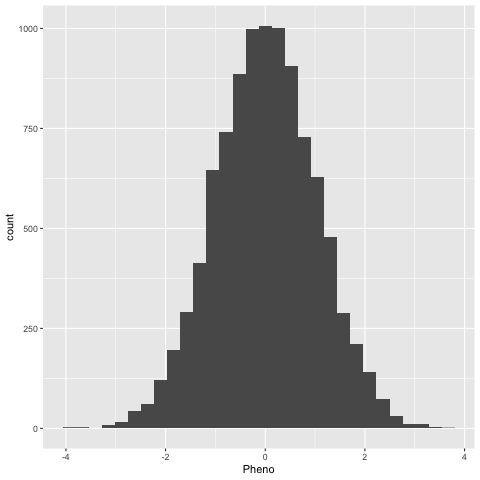

In [40]:
%%R
ggplot(phen, aes(Pheno)) + geom_histogram()

## Single-variant analysis by Plink

In [81]:
%%bash -s "$PLINK" "$D1_PHENO"
PLINK=$1
D1_PHENO=$2

cmd="$PLINK --bfile rv_geno_chr1_subset
    --pheno $D1_PHENO --pheno-name Pheno 
    --glm allow-no-covars --out gwas_sv"
eval $cmd

PLINK v2.00a3.7 64-bit (24 Oct 2022)           www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to gwas_sv.log.
Options in effect:
  --bfile rv_geno_chr1_subset
  --glm allow-no-covars
  --out gwas_sv
  --pheno ../data//rv_pheno.txt
  --pheno-name Pheno

Start time: Tue Apr 25 15:07:27 2023
16384 MiB RAM detected; reserving 8192 MiB for main workspace.
Using up to 12 threads (change this with --threads).
9953 samples (4942 females, 5011 males; 9953 founders) loaded from
rv_geno_chr1_subset.fam.
55 variants loaded from rv_geno_chr1_subset.bim.
1 quantitative phenotype loaded (9949 values).
Calculating allele frequencies... 0%0%done.
--glm linear regression on phenotype 'Pheno': 0%0%done.
Results written to gwas_sv.Pheno.glm.linear .
End time: Tue Apr 25 15:07:27 2023


Check the output file from Plink.

In [82]:
%%bash 
head gwas_sv.Pheno.glm.linear | cut -f 3,9-12 | column -t

ID              BETA        SE         T_STAT     P
1:12030946:T:C  0.0556835   0.102067   0.545557   0.585383
1:12032428:A:C  0.0641601   0.0772512  0.830538   0.406254
1:12057950:C:T  -0.323574   0.0801934  -4.03492   5.50288e-05
1:12095233:A:C  -0.0759753  0.0935782  -0.811891  0.416873
1:12100532:T:C  -0.100285   0.0909501  -1.10264   0.270211
1:12110879:T:C  0.00110483  0.0797892  0.0138469  0.988952
1:12121069:G:A  0.120369    0.0905905  1.32872    0.183972
1:12137783:C:T  0.070976    0.0805346  0.881311   0.378171
1:12137898:T:C  0.0397444   0.0951887  0.417533   0.676297


In [83]:
%%R
assoc_plink = fread('gwas_sv.Pheno.glm.linear') %>% as_tibble
str(assoc_plink)

tibble [55 × 13] (S3: tbl_df/tbl/data.frame)
 $ #CHROM : int [1:55] 1 1 1 1 1 1 1 1 1 1 ...
 $ POS    : int [1:55] 12030946 12032428 12057950 12095233 12100532 12110879 12121069 12137783 12137898 12143774 ...
 $ ID     : chr [1:55] "1:12030946:T:C" "1:12032428:A:C" "1:12057950:C:T" "1:12095233:A:C" ...
 $ REF    : chr [1:55] "C" "C" "T" "C" ...
 $ ALT    : chr [1:55] "T" "A" "C" "A" ...
 $ A1     : chr [1:55] "T" "A" "C" "A" ...
 $ TEST   : chr [1:55] "ADD" "ADD" "ADD" "ADD" ...
 $ OBS_CT : int [1:55] 9949 9949 9949 9949 9949 9949 9949 9949 9949 9949 ...
 $ BETA   : num [1:55] 0.0557 0.0642 -0.3236 -0.076 -0.1003 ...
 $ SE     : num [1:55] 0.1021 0.0773 0.0802 0.0936 0.091 ...
 $ T_STAT : num [1:55] 0.546 0.831 -4.035 -0.812 -1.103 ...
 $ P      : num [1:55] 0.585383 0.406254 0.000055 0.416873 0.270211 ...
 $ ERRCODE: chr [1:55] "." "." "." "." ...
 - attr(*, ".internal.selfref")=<externalptr> 


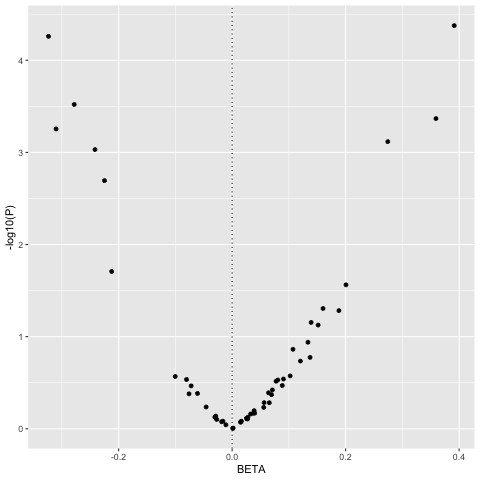

In [84]:
%%R
ggplot(assoc_plink, aes(BETA, -log10(P))) + geom_point() + geom_vline(xintercept = 0, linetype = 3)

## Burden test

Weighted burden test: for each individual, take a weighted count of the rare alleles across sites.

In [85]:
%%R
wts = dbeta(mafs, 1, 25)
burden = G * wts
burden[1:5, 1:3]

     1:12030946:T:C 1:12032428:A:C 1:12057950:C:T
5257        0.00000              0              0
4686        0.00000              0              0
5818        0.00000              0              0
659         0.00000              0              0
8446       21.49225              0              0


In [86]:
%%R
score = rowSums(burden)
table(score > 1)


FALSE  TRUE 
 4458  5495 


In [87]:
%%R
fit = lm(phen$Pheno ~ score)
summary(fit)


Call:
lm(formula = phen$Pheno ~ score)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9509 -0.6895 -0.0010  0.6796  3.6603 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 0.0001835  0.0135912   0.014    0.989
score       0.0007311  0.0005417   1.350    0.177

Residual standard error: 1.01 on 9947 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.0001831,	Adjusted R-squared:  8.258e-05 
F-statistic: 1.822 on 1 and 9947 DF,  p-value: 0.1772



The burden test (p-value ~ 0.2) seem to perform worse than single-variant tests (p-values up to 1e-4). What are possible explanations? How to improve the analysis?

## SKAT

In [88]:
%%R
null_skat = SKAT_Null_Model(phen$Pheno ~ 1 , out_type = "C")
res_skat = SKAT(G, null_skat)
str(res_skat)

List of 7
 $ p.value           : num 1.13e-10
 $ p.value.resampling: NULL
 $ Test.Type         : chr "davies"
 $ Q                 : num [1, 1] 4734150
 $ param             :List of 4
  ..$ liu_pval     : num 1.13e-10
  ..$ Is_Converged : num 0
  ..$ n.marker     : int 55
  ..$ n.marker.test: int 55
 $ pval.zero.msg     : NULL
 $ test.snp.mac      : Named num [1:55] 99 170 157 118 125 161 126 160 114 125 ...
  ..- attr(*, "names")= chr [1:55] "1:12030946:T:C" "1:12032428:A:C" "1:12057950:C:T" "1:12095233:A:C" ...
 - attr(*, "class")= chr "SKAT_OUT"


## SKAT-O

In [89]:
%%R
# rho = 1 --> SKAT-O = burden
res_skat_rho1 = SKAT(G, null_skat, r.corr = 1)
res_skat_rho1$p.value

[1] 0.1415765


In [90]:
%%R
# rho = 0 --> SKAT-O = SKAT or variance component test
res_skat_rho1 = SKAT(G, null_skat, r.corr = 0)
res_skat_rho1$p.value

[1] 1.130662e-10


In [91]:
%%R
# optimal rho
res_skat_o = SKAT(G, null_skat, method = "optimal.adj")
res_skat_o$p.value

[1] 7.914634e-10


In [93]:
%%R
wts_beta = dbeta(mafs, 1, 25)
wts_acat <- wts_beta * wts_beta * mafs * (1 - mafs)

ACAT(assoc_plink$P, weights = wts_acat)

[1] 0.001096681


In [94]:
%%R
min(assoc_plink$P) * nrow(assoc_plink)

[1] 0.002314175
